<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_4_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In this lab, we will set up a **data pipeline** in order to leave the data ready for analysis. Data preprocessing tends to be, by far, the most time-consuming step of the data science process. Errors in this step propagate to the model, so it is really important we do this correctly.

The goal of this step is to leave the date ready to apply models to it.

Every problem has its own set of data preprocessing functions to apply it to, but we will focus on the ones most common in classification models. In general we want to:

1. Eliminate redundant variables.
2. Treat null values.
3. Treat outliers.
4. Remove correlated features.

For this goal we will use the excellent [```scikit-learn```](https://scikit-learn.org/stable/) package, which comes with most data-intensive operations. We will also use today (and during the rest of the module) the [```pandas```](https://pandas.pydata.org/) package, which allows for data handling in general. Let's start by importing the packages we will use.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import zscore

## Reading the data

Let's download the Bankloan data. I have slightly modified it removing the PD and LGD information (as we will now estimate our own). As a reminder, it has the following variables:

- Customer: ID, or unique label, of the borrower (NOT predictive).
- Age: Age of the borrower in years.
- Education: Maximum education level the borrower reached.
1: Complete primary. 2: Completed Secondary. 3: Incomplete Higher Ed. 4: Complete Higher Ed. 5: With postgraduate studies (complete MSc or PhD).
- Employ: Years at current job.
- Address: Years at current address.
- Income: Income in ‘000s USD.
- Leverage: Debt/Income Ratio.
- CredDebt: Credit card standing debt.
- OthDebt: Other debt in ‘000s USD.
- MonthlyLoad: Monthly percentage from salary used to repay debts.
- Default: 1 If default has occurred, 0 if not (Target variable).

We will download it now directly from a link, using the more ubiquitous [```wget```](http://www.gnu.org/software/wget/) command. The command is

```
wget [-options] path
```

We need to add the options ```--no-check-certificate``` and ```--output-document=FILENAME``` so it downloads ok.

In [ ]:
!wget --no-check-certificate --output-document=Bankloan.csv 'https://docs.google.com/spreadsheets/d/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI/export?gid=1016776666&format=csv'

--2025-02-26 18:38:49--  https://docs.google.com/spreadsheets/d/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI/export?gid=1016776666&format=csv
Resolving docs.google.com (docs.google.com)... 172.217.204.100, 172.217.204.101, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.100|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0o-8s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/6bmo6rs275fr1o95ovd5mjocc4/1740595125000/102123285539774178265/*/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI?gid=1016776666&format=csv [following]
--2025-02-26 18:38:49--  https://doc-0o-8s-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/6bmo6rs275fr1o95ovd5mjocc4/1740595125000/102123285539774178265/*/1nUJ1fA5f1VeMvulknpsvxpy0GW3CekNnhgeLRK0WlDI?gid=1016776666&format=csv
Resolving doc-0o-8s-sheets.googleusercontent.com (doc-0o-8s-sheets.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::

To check what we downloaded we can use the ```head``` OS command.

In [ ]:
!head Bankloan.csv

customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
10012,28,Med,7,2,44,17.7,2.99,4.8,0.58,0
10017,64,Posg,34,17,116,14.7,5.05,12,0.27,0
10030,40,Bas,20,12,61,4.8,1.04,1.89,0.13,0
10039,30,Bas,11,3,27,34.5,1.75,7.56,1.62,0
10069,25,Bas,2,2,30,22.4,0.76,5.96,0.97,1
10071,35,Bas,2,9,38,10.9,1.46,2.68,0.4,1
10096,26,SupInc,2,4,38,11.9,0.95,3.57,0.43,1
10128,25,Bas,4,2,30,14.4,1.05,3.27,0.62,0
10129,65,SupCom,29,14,189,5,3.36,6.09,0.08,0


Now we will use Pandas to read the CSV file. The  function to do so is [```read_csv```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). We will store the results in a variable named ```bankloan_data```.

In [ ]:
bankloan_data = pd.read_csv('Bankloan.csv')

As a reminder, here are the summary statistics of the variables.

In [ ]:
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1500.000000,1500.000000,1500.000000,1499.000000,1499.000000,1499.000000,1499.000000,1489.000000,1500.000000,1500.000000
mean,257714.548000,34.174000,6.952000,6.309540,59.615077,677.046631,1.936197,3.872257,0.365447,0.365333
std,139555.147719,13.142306,8.977644,6.047563,67.144768,25828.218141,2.974485,5.343150,0.293937,0.481684
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.100000,0.000000,0.100000,0.000000,0.000000
25%,98638.750000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.120000,0.150000,0.000000
50%,315991.500000,31.000000,4.000000,5.000000,40.000000,8.500000,0.990000,2.240000,0.290000,0.000000
75%,370701.500000,42.000000,10.000000,9.000000,64.000000,13.600000,2.200000,4.610000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,1079.000000,999999.000000,35.970000,63.470000,2.150000,1.000000


In [ ]:
bankloan_data.columns

Index(['customer', 'Age', 'Education', 'Employ', 'Address', 'Income',
       'Leverage', 'Creddebt', 'OthDebt', 'MonthlyLoad', 'Default'],
      dtype='object')

We can see there are a few null values in different variables and apparently an invalid outlier in Leverage.  Let's visualize the dataset using seaborn to get an idea of the distribution.

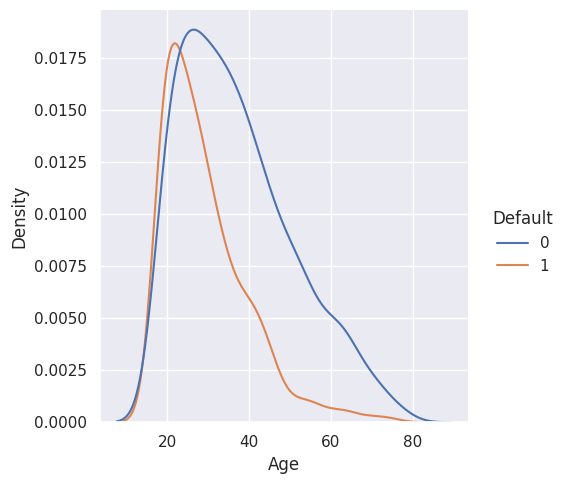

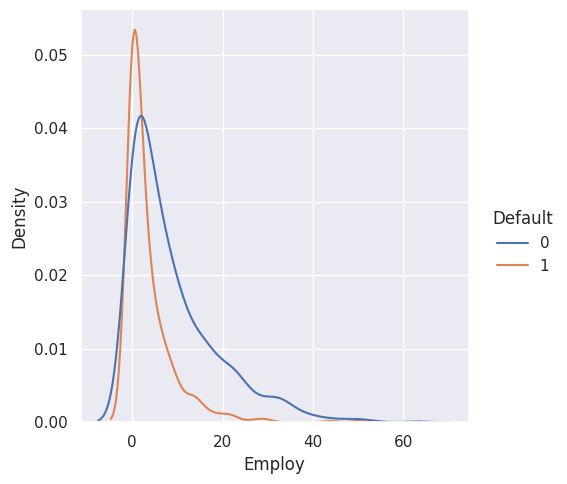

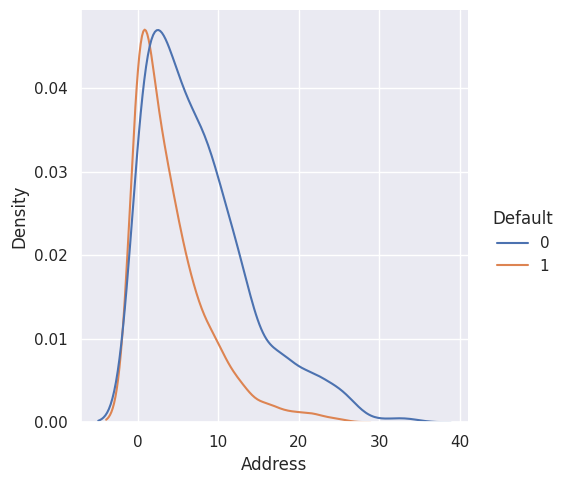

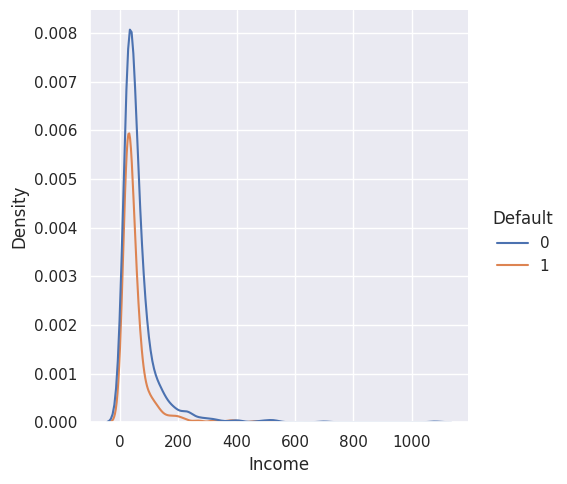

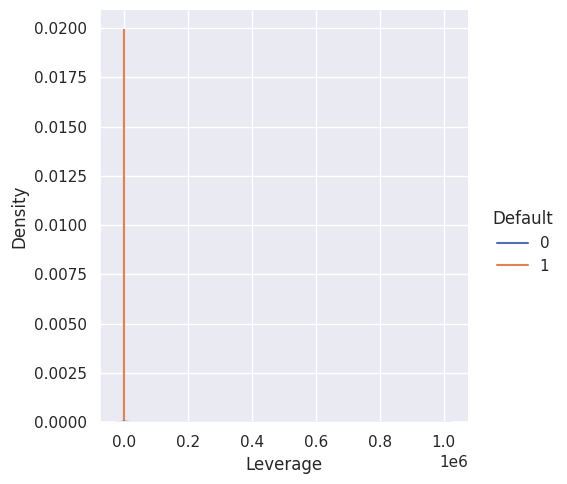

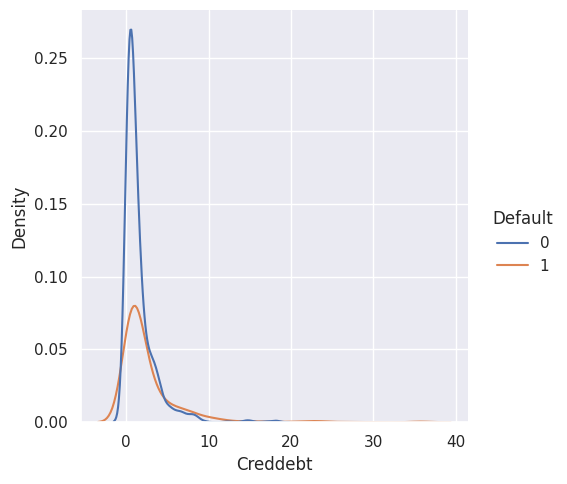

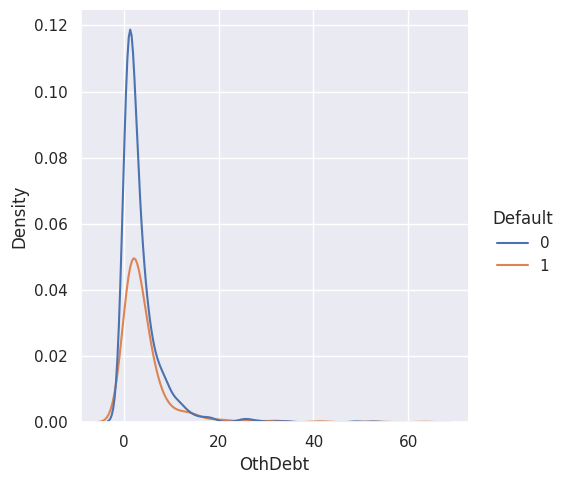

In [ ]:
# Set the theme of the plots
sns.set_theme(color_codes=True)

# Plot the distribution of the columns. Ignore the warning, it is internal to seaborn
for col_id in bankloan_data.columns[np.r_[1,3:9]]:
    sns.displot(data = bankloan_data, x = col_id, hue = "Default", kind = 'kde')

Seaborn can do many sophisticated (and aestetically pleasing)
graphs. Go to [the Gallery](https://seaborn.pydata.org/examples/index.html) for details and example code.

There are severe outliers in OthDebt, Leverage, Creddebt and Income, but we don't know which ones are valid and which invalid. We will treat these now.

## Data Cleaning

Now we can focus on cleaning the data. Let's start with the easy part: removing null values. **Remember to check when an outlier is a missing value** (invalid outliers).

### Null values

The core function here will be Panda's [```fillna```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). This allows to replace all null values (represented by None or NaN in Python) by a certain value. This also allows to set what the replacement will be with the ```value``` argument. See the help for details.

Remember the strategies to deal :

1. Keep: If the null values are a category by themselves. In this case, replace by something meaningful.

2. Delete: If the null values are too many **either by row or by column** then it is better to just drop the case or the variable.

3. Replace: If there are only a few missings for the variable or the row (<1% total), replace by the  replace the null values by the **median** for continous variables, and the **mode** for categorical values.

Let's study our dataset's null values. The [```isnull()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) function returns which elements in the dataframe are null. The [```any()```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.any.html) function returns a list with whatever columns (default) or rows (passing ```axis = 1``` to the function) have any element with a boolean of true.

In [ ]:
bankloan_data.isnull().any()

,0
customer,False
Age,False
Education,False
Employ,False
Address,True
Income,True
Leverage,True
Creddebt,True
OthDebt,True
MonthlyLoad,False


We can see which columns have null values. Let's study them in further detail.

In [ ]:
null_columns = bankloan_data.columns[bankloan_data.isnull().any()]
bankloan_data[null_columns].isnull().sum()

,0
Address,1
Income,1
Leverage,1
Creddebt,1
OthDebt,11


Given the small number of cases for all variables except OthDebt, we can simply replace those values by the median.

Let's study OthDebt cases more in detail.

In [ ]:
bankloan_data.loc[bankloan_data.isnull().any(axis = 1), :]

,customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
17,10423,19,Bas,2,0.0,31.0,0.3,0.02,NaN,0.01,1
247,71896,20,SupInc,0,0.0,21.0,1.3,0.18,NaN,0.07,1
255,72327,19,Med,0,NaN,NaN,NaN,NaN,NaN,0.01,1
293,74471,39,Bas,8,9.0,41.0,0.1,0.03,NaN,0.00,0
587,244023,31,SupCom,1,7.0,69.0,0.4,0.19,NaN,0.01,0
745,315892,22,SupInc,0,1.0,14.0,2.5,0.26,NaN,0.20,0
748,315948,41,Med,21,9.0,64.0,0.3,0.12,NaN,0.01,0
817,335635,18,Med,0,0.0,24.0,0.9,0.13,NaN,0.05,1
1194,372485,20,SupInc,0,0.0,13.0,1.1,0.05,NaN,0.10,0
1254,376801,23,SupCom,0,2.0,19.0,1.4,0.18,NaN,0.09,0


We can see all cases in which OthDebt is null. We can also see the egregious outlier that Leverage has, with a value of 9999999. These values give us some hints about what's happening with OthDebt. Let's study the minimum and maximum of the variables.

In [ ]:
bankloan_data.OthDebt.describe()

,OthDebt
count,1489.000000
mean,3.872257
std,5.343150
min,0.100000
25%,1.120000
50%,2.240000
75%,4.610000
max,63.470000


Aha! Note anything? There are no values equal to 0! We can make a good guess that the null values are equal to zero. In real life we would call the sysadmins to confirm this, but in this case we can make a guess.

Then, we now should fix these values as follow:

1. Replace the leverage equal to 999999 by a null value.
2. Replace all OthDebt nulls by 0.
3. Replace the remaining null values by the median.

In [ ]:
# Replace invalid outlier.
bankloan_data.Leverage.values[bankloan_data.Leverage.values == 999999] = np.nan

In [ ]:
# Fills out the null values with zeros. Inplace argument changes dataframe.
bankloan_data.fillna(value={'OthDebt': 0}, inplace=True)

In [ ]:
# Remove null case if you want
# bankloan_data.drop(index=255, axis=0, inplace = True)

In [ ]:
# Get the column names for columns with null values.
null_columns = bankloan_data.columns[bankloan_data.isnull().any()]

# Creates dictionary of the column names and the median of the column.
dict_median = {column: bankloan_data[column].median() for column in null_columns}
print(dict_median)

# Fill the NA/NaN values with the median of the column.
bankloan_data.fillna(value=dict_median, inplace=True)

{'Address': 5.0, 'Income': 40.0, 'Leverage': 8.5, 'Creddebt': 0.99}


In [ ]:
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,257714.548000,34.174000,6.952000,6.308667,59.602000,9.940600,1.935567,3.843860,0.365447,0.365333
std,139555.147719,13.142306,8.977644,6.045640,67.124278,6.662313,2.973593,5.333758,0.293937,0.481684
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,98638.750000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.107500,0.150000,0.000000
50%,315991.500000,31.000000,4.000000,5.000000,40.000000,8.500000,0.990000,2.215000,0.290000,0.000000
75%,370701.500000,42.000000,10.000000,9.000000,64.000000,13.525000,2.200000,4.572500,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,1079.000000,40.700000,35.970000,63.470000,2.150000,1.000000


There are no more null values! We are now ready to study the distributions.

### Outlier cleaning

Cleaning outlier, on the other hand, requires a much more manual intervention. We know there are three variables we need to intervene in: Income, Creddebt, and OthDebt. In general, we would like to modify all cases where there is either a discontinuous distribution or a case that is outside of 3 to 6 standard deviations.

It is very important to use your judgement in this! Don't just cut in 3 stds, as that is too restrictive in an exponential distribution. If you want to get an idea of the values, then seaborn can help. The function ```displot``` with either the option ```hist``` or ```kde``` allows to check the distribution of values.

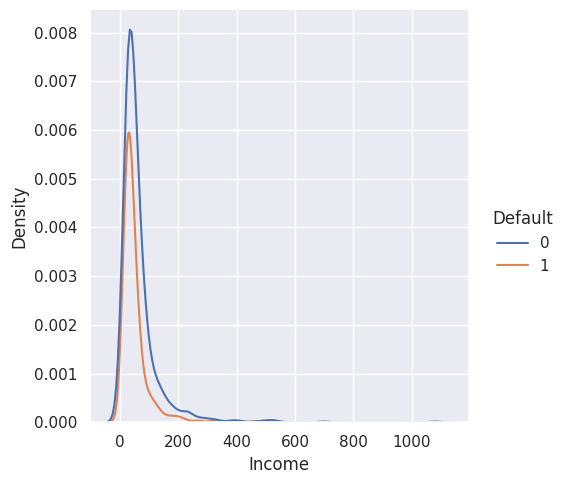

In [ ]:
fig = sns.displot(data=bankloan_data, x='Income', kind='kde', hue='Default')
plt.savefig('Income.pdf')
plt.show()

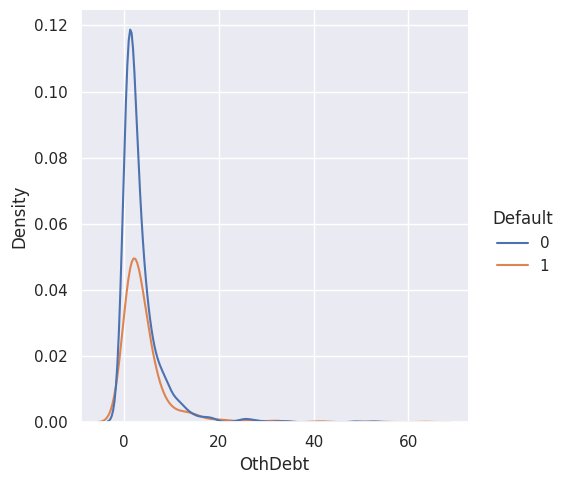

In [ ]:
sns.displot(data = bankloan_data, x ='OthDebt', kind='kde', hue='Default')
plt.show()

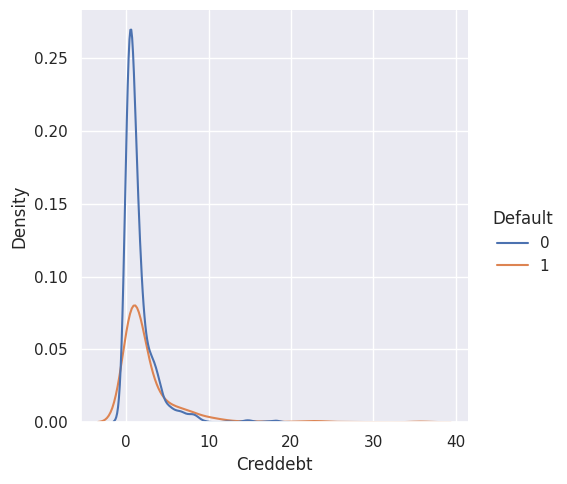

In [ ]:
fig = sns.displot(data = bankloan_data, x = 'Creddebt', kind = 'kde', hue = 'Default')
plt.savefig('Creddebt.pdf')
plt.show()

Income needs to be trimmed from the right. Potential cutoffs are Income of 450. OthDebt and Creddebt need to be truncated or left as is.

To actually cut the values, then we can simply write a proper expression in Pandas:

In [ ]:
bankloan_data['Income'].sort_values(ascending=False).head(n=50)

,Income
1198,1079.0
468,699.0
1461,533.0
1435,526.0
776,512.0
234,497.0
1314,493.0
489,475.0
939,460.0
192,410.0


In [ ]:
bankloan_data = bankloan_data.loc[bankloan_data['Income'] < 300]

We can check now how the data looks like.

<ipython-input-56-6be3fba35ce8>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90);


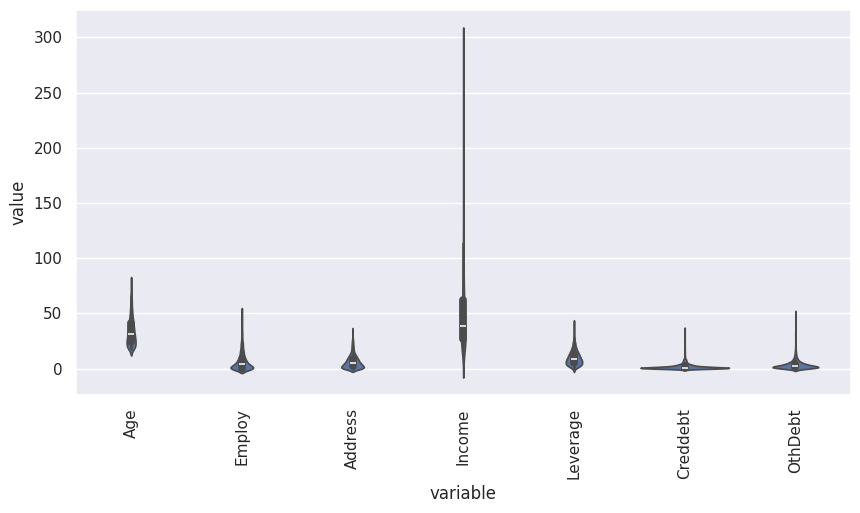

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(bankloan_data.iloc[:, np.r_[1,3:9]]), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

In [ ]:
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000
mean,257591.192828,33.820704,6.589310,6.173207,53.795670,9.975237,1.800298,3.590135,0.369465,0.366035
std,139579.702866,12.838761,8.382677,5.949440,43.104055,6.665023,2.514837,4.467314,0.294106,0.481882
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,98310.250000,24.000000,0.000000,2.000000,27.000000,4.900000,0.420000,1.082500,0.160000,0.000000
50%,316030.000000,31.000000,4.000000,5.000000,39.000000,8.600000,0.950000,2.190000,0.300000,0.000000
75%,370670.750000,41.000000,9.000000,9.000000,62.000000,13.600000,2.130000,4.450000,0.500000,1.000000
max,453777.000000,77.000000,51.000000,34.000000,289.000000,40.700000,35.970000,50.220000,2.150000,1.000000


Much better, although income still has a large outlier. This plot might be misleading though, as the magnitud of the data is relevant. We might want to recheck this after normalizing the data. We will now save the output to a compressed format which is very efficient to start whole data structures, [pickle](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_pickle.html).

In [ ]:
bankloan_data.to_pickle('BankloanClean.pkl')

## Standardization

Most models require the inputs to be in the same scale, this is called **normalization**. It is very important for most models... except for credit scoring as we will use Weight of Evidence (see the lecture!). Still, this is fairly simple to do in Pandas, being smart about what columns we select and **mapping** a function to those columns.

The most traditional mapping is the zscore. We can use scipy's version of it.



We now select all numeric columns, except the customer one. We can do this with ```select_dtypes```.

In [ ]:
# Identify the numerical columns
numeric_cols = bankloan_data.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['customer', 'Age', 'Employ', 'Address', 'Income', 'Leverage',
       'Creddebt', 'OthDebt', 'MonthlyLoad', 'Default'],
      dtype='object')

In [ ]:
# Remove the first and last one
numeric_cols = numeric_cols[1:-1]

In [ ]:
# Apply the zscore function to all data
bankloan_data[numeric_cols] = bankloan_data[numeric_cols].apply(zscore)

Now the data should look much better.

<ipython-input-62-6be3fba35ce8>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90);


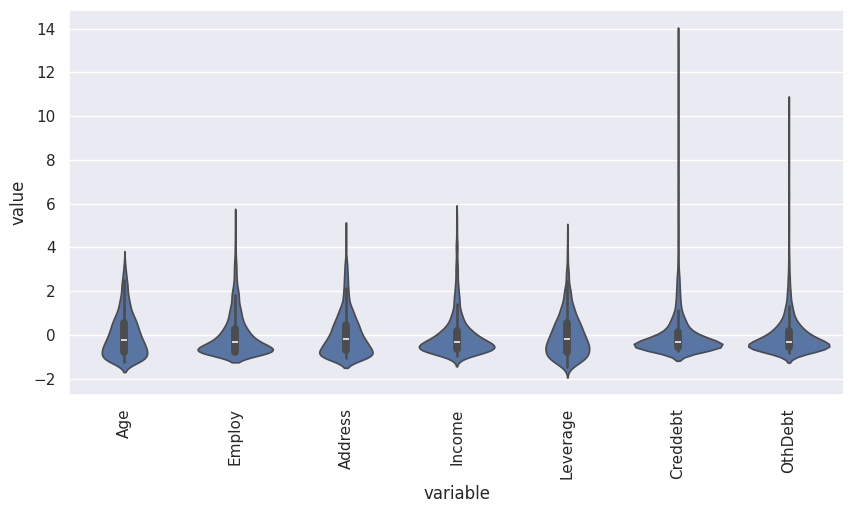

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(bankloan_data.iloc[:, np.r_[1,3:9]]), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

The dataset looks really clean now, but we should study the outliers in CredDebt and OthDebt. We are ready to use further models! To be 100% purist **you should first split between train and test set** before doing all of these analyses (so you should use the median of the train set). Please remember that when solving your coursework.

## Dummy coding

The final step will be transform the categorical variables to dummy variables. Again, this is **not necessary for credit scoring** as the WoE transform is much more robust. The best strategy here is to follow the 5% rule:

1. Aggregate by expert judgement (i.e. your opinion) until each group has more than 5% of data (1% if very large data) and there are all classes (by target variable) present.

2. Use target variable percentage (or classification trees) until you get a proper number of groups.

To check the number of cases for each default level, we can calculate a crosstab.

In [ ]:
pd.crosstab(bankloan_data['Education'], bankloan_data['Default'])

Default,0,1
Education,,
Bas,180,64
Med,325,196
Posg,54,26
SupCom,167,137
SupInc,211,118


We are looking for:
1. Every category should have a significant number of cases overall.
2. Every category should have a meaningful number of cases in each category.

If any of these conditions are not set, then you must first group **manually** categories that make sense (using the meaning of the categories), as this means the category is not statistically significant.

Now we can calculate the mean of each educational level.

In [ ]:
bankloan_data.groupby('Education', as_index=False).agg({'Default': ["mean"]})

,Education,Default
,,mean
0,Bas,0.262295
1,Med,0.376200
2,Posg,0.325000
3,SupCom,0.450658
4,SupInc,0.358663


These categories are all meaningful. If, for example, PosGrad were not, we could group it together with SupComp.

Once we are confident,  we can create dummy variables directly with Pandas [```get_dummies```](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [ ]:
bankloan_data = pd.get_dummies(bankloan_data)
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1478.000000,1.478000e+03,1.478000e+03,1.478000e+03,1.478000e+03,1.478000e+03,1.478000e+03,1.478000e+03,1.478000e+03,1478.000000
mean,257591.192828,-2.427768e-16,1.201865e-17,-4.326715e-17,4.807461e-17,-2.764290e-17,-2.644104e-17,1.490313e-16,2.331619e-16,0.366035
std,139579.702866,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,1.000338e+00,0.481882
min,10012.000000,-1.232678e+00,-7.863288e-01,-1.037963e+00,-9.699741e-01,-1.482152e+00,-7.161127e-01,-8.039171e-01,-1.256656e+00,0.000000
25%,98310.250000,-7.651850e-01,-7.863288e-01,-7.016827e-01,-6.218612e-01,-7.617310e-01,-5.490474e-01,-5.615195e-01,-7.124507e-01,0.000000
50%,316030.000000,-2.197765e-01,-3.089927e-01,-1.972629e-01,-3.433709e-01,-2.064062e-01,-3.382268e-01,-3.135238e-01,-2.362716e-01,0.000000
75%,370670.750000,5.593785e-01,2.876773e-01,4.752968e-01,1.904022e-01,5.440327e-01,1.311472e-01,1.925443e-01,4.439844e-01,1.000000
max,453777.000000,3.364336e+00,5.299706e+00,4.678795e+00,5.458511e+00,4.611412e+00,1.359184e+01,1.044154e+01,6.056096e+00,1.000000


Now we are ready to apply general models!